In [2]:
import os
import random
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [3]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=2, init_features=64):
        super().__init__()
        features = init_features
        kernel_size = 3
        self.encoder1 = block(in_channels, features, kernel_size, "enc1")
        self.pool = nn.MaxPool2d(stride=2, kernel_size=2)
        self.encoder2 = block(features, features * 2, kernel_size, "enc2")
        self.encoder3 = block(features * 2, features * 4, kernel_size, "enc3")
        self.encoder4 = block(features * 4, features * 8, kernel_size, "enc4")
        self.bottleneck_encoder = block(
            features * 8, features * 16, kernel_size, "bottleneck_enc"
        )
        self.upconv1 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder1 = block(features * 16, features * 8, kernel_size, "dec1")
        self.upconv2 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder2 = block(features * 8, features * 4, kernel_size, "dec2")
        self.upconv3 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder3 = block(features * 4, features * 2, kernel_size, "dec3")
        self.upconv4 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder4 = block(features * 2, features, kernel_size, "dec4")
        self.out_conv = nn.Conv2d(features, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        bottleneck = self.bottleneck_encoder(self.pool(enc4))

        upconv1 = self.upconv1(bottleneck)
        crop_bot, crop_top = crop_size(enc4, upconv1)
        dec1 = self.decoder1(
            torch.cat(
                (enc4[:, :, crop_bot:crop_top, crop_bot:crop_top], upconv1), dim=1
            )
        )

        upconv2 = self.upconv2(dec1)
        crop_bot, crop_top = crop_size(enc3, upconv2)
        dec2 = self.decoder2(
            torch.cat(
                (enc3[:, :, crop_bot:crop_top, crop_bot:crop_top], upconv2), dim=1
            )
        )

        upconv3 = self.upconv3(dec2)
        crop_bot, crop_top = crop_size(enc2, upconv3)
        dec3 = self.decoder3(
            torch.cat(
                (enc2[:, :, crop_bot:crop_top, crop_bot:crop_top], upconv3), dim=1
            )
        )

        upconv4 = self.upconv4(dec3)
        crop_bot, crop_top = crop_size(enc1, upconv4)
        dec4 = self.decoder4(
            torch.cat(
                (enc1[:, :, crop_bot:crop_top, crop_bot:crop_top], upconv4), dim=1
            )
        )

        output = self.out_conv(dec4)
        return output


def crop_size(encoder, upconv) -> tuple:
    "Return crop size of encoder's feature maps so it fits upconv's shape"
    x = encoder.shape[2]
    y = upconv.shape[2]
    return (x - y) // 2, (x + y) // 2


def block(
    in_channels: int, features: int, kernel_size: int, name: str
) -> nn.Sequential:
    # TODO add BatchNorm2d?
    return nn.Sequential(
        OrderedDict(
            [
                (f"{name}_conv1", nn.Conv2d(in_channels, features, kernel_size)),
                (f"{name}_relu1", nn.ReLU(inplace=True)),
                (f"{name}_conv2", nn.Conv2d(features, features, kernel_size)),
                (f"{name}_relu2", nn.ReLU(inplace=True)),
            ]
        )
    )

In [4]:
model = UNet()

In [5]:
model.forward(torch.Tensor(1, 1, 572, 572)).shape

torch.Size([1, 2, 388, 388])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir: str, mask_dir: str, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        # self.images = random.sample(os.listdir(image_dir), 1095)
        self.images = os.listdir(image_dir)
        self.image_data = []
        self.mask_data = []
        for image_name in self.images:
            image_path = os.path.join(self.image_dir, image_name)
            mask_path = os.path.join(self.mask_dir, image_name)
            image = Image.open(image_path).convert("L")
            mask = Image.open(mask_path).convert("L")
            self.image_data.append(image)
            self.mask_data.append(mask)

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx):
        image = self.image_data[idx]
        mask = self.mask_data[idx]

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask


class ImageMaskTransform:
    def __init__(
        self, flip_prob=0.5, rotation_degree=30, train=True, crop_size=388, pad_width=30
    ):
        self.flip_prob = flip_prob
        self.rotation_degree = rotation_degree
        self.train = train
        target_size = 512
        self.crop_start = (target_size - crop_size) // 2
        self.crop_end = (target_size + crop_size) // 2
        self.pad_width = pad_width

    def __call__(self, image, mask):
        image = np.pad(image, pad_width=self.pad_width, mode="reflect")
        mask = np.array(mask)[
            self.crop_start : self.crop_end, self.crop_start : self.crop_end
        ]
        # TODO add augmentations
        # if self.train:
        #     image = Image.fromarray(image)
        #     mask = Image.fromarray(mask)
        #     if random.random() < self.flip_prob:
        #         image = transforms.functional.hflip(image)
        #         mask = transforms.functional.hflip(mask)

        #     angle = random.uniform(-self.rotation_degree, self.rotation_degree)
        #     image = transforms.functional.rotate(image, angle)
        #     mask = transforms.functional.rotate(mask, angle)

        image = transforms.ToTensor()(image)
        mask = transforms.ToTensor()(mask).long()
        return image, mask

In [7]:
def iou_loss(predictions, targets, eps=1e-6):
    intersection = torch.sum(predictions * targets)
    union = torch.sum(predictions + targets) - intersection
    iou = (intersection + eps) / (union + eps)
    return iou


class CrossEntropyIoULoss(nn.Module):
    def __init__(self):
        super(CrossEntropyIoULoss, self).__init__()
        self.ce = nn.CrossEntropyLoss()

    def forward(self, outputs, targets):
        ce_loss = self.ce(outputs, targets)
        return ce_loss
        # TODO add IOU
        # return bce_loss + iou_loss(outputs, targets)

In [8]:
train_transform = ImageMaskTransform()

base_dir = "/content/drive/MyDrive/Colab_Notebooks/Crack_Detection/"
base_dir = './'
train_image_dir = base_dir + "isbi_2012_challenge/train/imgs"
train_mask_dir = base_dir + "isbi_2012_challenge/train/labels"
batch_size = 1
train_dataset = SegmentationDataset(
    train_image_dir, train_mask_dir, transform=train_transform
)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_image_dir = base_dir + "isbi_2012_challenge/test/imgs"
test_mask_dir = base_dir + "isbi_2012_challenge/test/labels"

test_transforms = ImageMaskTransform(train=False)
test_dataset = SegmentationDataset(
    test_image_dir, test_mask_dir, transform=test_transforms
)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

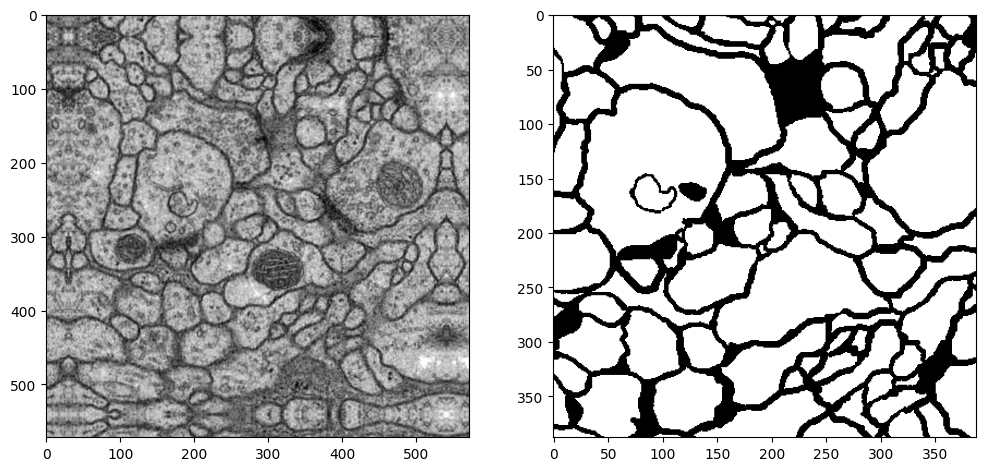

(388, 388)
[[1 1 1 ... 0 0 1]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


In [9]:
images, masks = next(iter(train_dataloader))
image = images[0].permute(1, 2, 0).cpu().numpy()
mask = masks[0].cpu().numpy().squeeze()
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(image, cmap="gray")
axs[1].imshow(mask, cmap="gray")
plt.show()
print(mask.shape)
print(mask)

In [11]:
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
num_epochs = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = CrossEntropyIoULoss()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.squeeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print("Loss:", train_loss / len(train_dataloader))

KeyboardInterrupt: 

In [ ]:
data_iter = iter(test_dataloader)
# data_iter = iter(train_dataloader)
for _ in range(6):
    images, masks = next(data_iter)
    outputs = model(images)

    image = images[0].permute(1, 2, 0).cpu().numpy()
    mask = masks[0].cpu().numpy().squeeze()

    predictions = torch.sigmoid(outputs[0])
    predicted_mask = (predictions > 0.5).cpu().numpy().squeeze()

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    axs[0].imshow(image)
    axs[0].set_title("Image")
    axs[0].axis("off")

    axs[1].imshow(mask, cmap="gray")
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis("off")

    axs[2].imshow(predicted_mask, cmap="gray")
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")

plt.show()

In [ ]:
torch.save(model.state_dict(), checkpoint_path)